## Dataset information as per Kaggle (https://www.kaggle.com/competitions/icr-identify-age-related-conditions/data)

1. **train.csv** - The training set.
   * `Id` Unique identifier for each observation.
   * `AB-GL` Fifty-six anonymized health characteristics. All are numeric except for EJ, which is categorical.
   * `Class` A binary target: 1 indicates the subject has been diagnosed with one of the three conditions, 0 indicates they have not.
2. **test.csv** - The test set. Your goal is to predict the probability that a subject in this set belongs to each of the two classes.
3. **greeks.csv** - Supplemental metadata, only available for the training set.
   * `Alpha` Identifies the type of age-related condition, if present.
     * `A` No age-related condition. Corresponds to class 0.
     * `B`, `D`, `G` The three age-related conditions. Correspond to class 1.
   * `Beta`, `Gamma`, `Delta` Three experimental characteristics.
   * `Epsilon` The date the data for this subject was collected. Note that all of the data in the test set was collected after the training set was collected.

# To-do for preprocessing

1. Class weights
2. Finalize hyperparameters
   1. n_neighbors
   2. num_features
   3. ~~Test % split~~ 80-20
3. kPCA vs PCA -> **Go with PCA** maybe ask Cornelia
   1. kPCA over PCA if the data is nonlinear, but what's the best way to determin linearity?

In [1]:
# standard
import pandas as pd
import numpy as np
import random
import os

# tf, keras, and sklearn
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA

# Unused atm
from sklearn.decomposition import KernelPCA

from mlxtend.plotting import heatmap

# Stats library
import statsmodels.api as sm

# plots and images
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image

In [2]:
greeks = pd.read_csv('../data/greeks.csv')
#test = pd.read_csv('../data/test.csv')
train = pd.read_csv('../data/train.csv')

greeks.columns = map(str.lower, greeks.columns)
#test.columns = map(str.lower, test.columns)
train.columns = map(str.lower, train.columns)

print('Shape of greeks df:', greeks.shape)
#print('Shape of test df:', test.shape)
print('Shape of train df:', train.shape)

# Merge train and greeks to get all columns in the same DataFrame
df = pd.merge(train, greeks, on='id')

Shape of greeks df: (617, 6)
Shape of train df: (617, 58)


In [3]:
# One-hot encode EJ so it could be used in tSNE or PCA
train = train.join(pd.get_dummies(train['ej'], dtype=int))
train.drop(['ej'], axis=1, inplace=True)

# Binary target variable
target_variable = train['class']
features_variable = train.drop(['class', 'id'], axis=1)

# Fill in NaN values via KNNImputer
imputer = KNNImputer(n_neighbors=2)
features_variable = pd.DataFrame(imputer.fit_transform(features_variable))

In [4]:
def feature_reduction(method, num_features, data_split):
    if method == 'pca':
        # Split into Train and Test
        X_train, X_test, Y_train, Y_test = train_test_split(features_variable, target_variable, test_size = data_split,
                                                            stratify=target_variable, random_state=0)
        # Standardize values via StandardScaler
        sc = StandardScaler().fit(X_train)

        X_train_std = sc.transform(X_train)
        X_test_std = sc.transform(X_test)

        # PCA
        pca = PCA(n_components = num_features)
        pca.fit(X_train_std)
        X_train_pca = pd.DataFrame(pca.transform(X_train_std))
        X_test_pca = pd.DataFrame(pca.transform(X_test_std))

        return X_train_pca, X_test_pca, Y_train, Y_test
    
    elif method == 'tsne':
        # Standardize values via StandardScaler
        sc = StandardScaler().fit(features_variable)
        features_variable_std = sc.transform(features_variable)

        tsne = TSNE(n_components=num_features, random_state=0, perplexity=50, n_iter=5000, method = 'exact')

        # Calculate the 12 features via tSNE model
        features_variable_tsne = pd.DataFrame(tsne.fit_transform(features_variable_std))

        #Split into Train and Test
        X_train, X_test, Y_train, Y_test = train_test_split(features_variable_tsne, target_variable, test_size = data_split,
                                                            stratify=target_variable, random_state=0)
        return X_train, X_test, Y_train, Y_test


In [5]:
X_train, X_test, Y_train, Y_test = feature_reduction('pca', 12, 0.2)

In [6]:
display(X_train.head())

# Display old features shape
display(features_variable.shape)

# Display new tSNE features shape
display(X_train.shape)

,0,1,2,3,4,5,6,7,8,9,10,11
0,-0.690887,0.685788,1.006226,-1.171854,0.136816,0.093421,-0.481733,0.392191,-0.176123,-0.091700,0.733868,0.657149
1,-0.441772,0.454223,1.462607,-0.617965,-0.293618,0.023432,0.153689,-1.660740,-0.165092,0.878005,-0.642158,0.275903
2,0.671402,-1.941961,-1.723888,0.351624,0.629489,1.202796,1.880502,1.530765,-0.002930,0.937556,0.204159,-0.548910
3,-1.129595,-1.193760,1.500116,-0.829614,0.123395,0.421081,1.446770,-1.168590,0.334539,0.943517,-0.338204,0.785334
4,-0.449661,0.533336,-2.227092,1.630291,-0.744035,-0.592698,0.645509,-0.155894,-1.008784,0.356228,1.087015,-0.906472


(617, 57)

(493, 12)

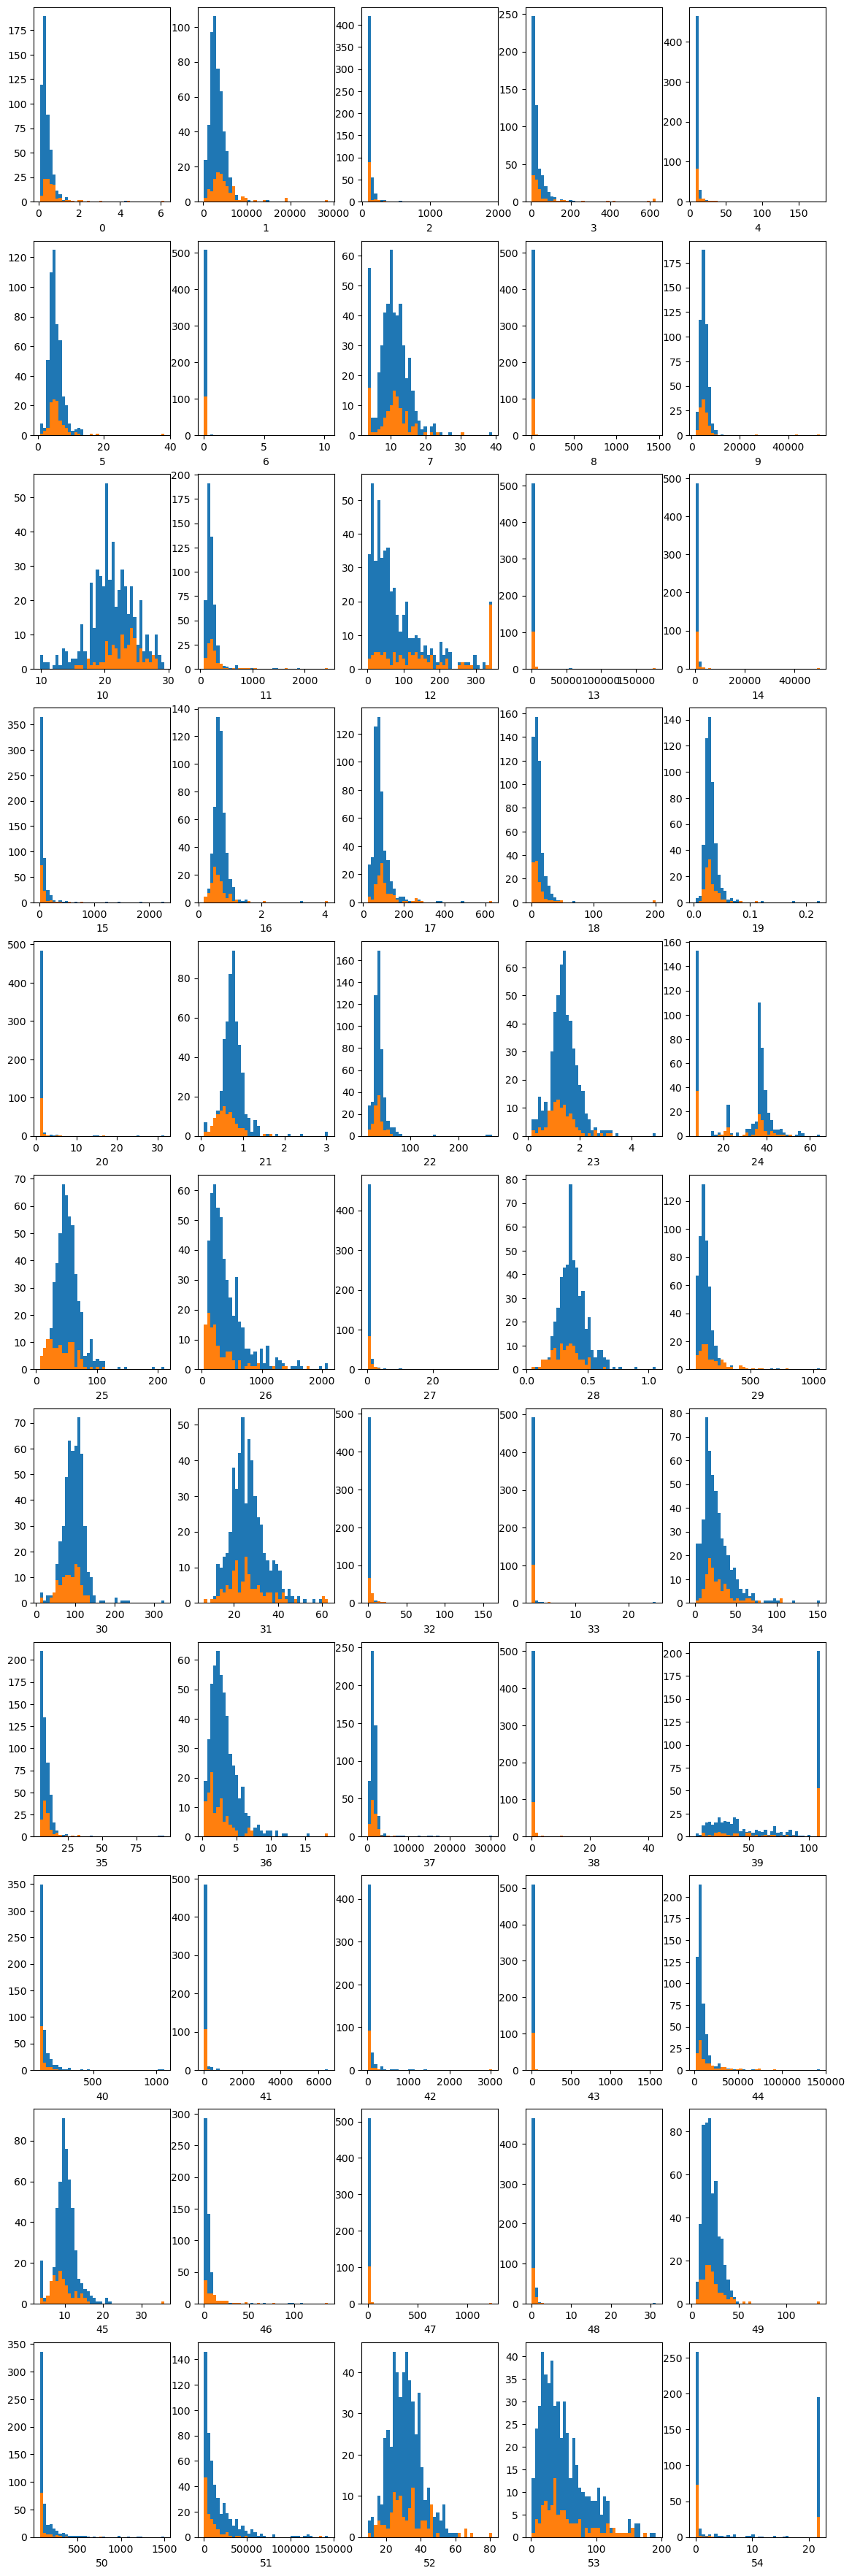

In [7]:
##########################################
### This is on 100% of the data, needs ###
### needs to be on split data.         ###
##########################################

df_train = pd.DataFrame(features_variable).join(target_variable)
columns = list(df_train.columns)
fig, axes = plt.subplots(nrows=11, ncols=5, figsize=(14,45))
for idx, ax in enumerate(axes.flatten()):
    # plot histogram
    # if(columns[idx] in ['EJ','Beta','Gamma','Delta']):
    #     no_disease = df_train[df_train['Alpha']==0][columns[idx]]
    #     disease = df_train[df_train['Alpha']!=0][columns[idx]]
    #     ax.hist(no_disease)
    #     ax.hist(disease)
    # else:
    no_disease = df_train[df_train['class']==0][columns[idx]]
    disease = df_train[df_train['class']!=0][columns[idx]]
    bins=np.histogram(np.hstack((no_disease,disease)), bins=40)[1]
    ax.hist(no_disease, bins)
    ax.hist(disease, bins)
    # set xlabel
    ax.set_xlabel(columns[idx])

### Modelling

Build the Model

In [15]:
def build_model(hidden_layer_sizes=[],
                activation='relu',
                optimizer='Adam',
                learning_rate=0.01):
    
    """Build a binary-class logistic regression model using Keras.

    Args:
      hidden_layer_sizes: A list with the number of units in each hidden layer.
      activation: The activation function to use for the hidden layers.
      optimizer: The optimizer to use (SGD, Adam).
      learning_rate: The desired learning rate for the optimizer.

    Returns:
      model: A tf.keras model (graph).
    """
    
    # Clear session and set a random seed for consistent behavior.
    tf.keras.backend.clear_session()
    np.random.seed(0)
    tf.random.set_seed(0)
    
    # Use Keras Sequential API to build the model
    model = tf.keras.Sequential()
    
    # create hidden layers
    for layer_size in hidden_layer_sizes:
        model.add(tf.keras.layers.Dense(units=layer_size,activation=activation))
    
    # create output layer
    model.add(tf.keras.layers.Dense(
          units=1,  # output dim for binary classification problem
          use_bias=True,
          activation='sigmoid', # sigmoid rather than softmax for a binary classification problem
          kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01),
          bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.01),
          name='Output'
    ))
  
    # Specify optimizer
    if optimizer == 'Adam':
        selected_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == 'SGD':
        selected_optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    
    # Using Binary Crossentropy loss
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(), 
                optimizer=selected_optimizer, 
                metrics=[tf.keras.metrics.binary_accuracy])

    return model

Run Experiments

In [101]:
def train_and_evaluate(hidden_layer_sizes=[],
                       activation='relu',
                       optimizer='Adam',
                       learning_rate=0.01,
                       num_epochs=5):

  # Build the model.
  model = build_model(hidden_layer_sizes=hidden_layer_sizes,
                      activation=activation,
                      optimizer=optimizer,
                      learning_rate=learning_rate)

  # Train the model.
  print('Training...')
  history = model.fit(
    x=X_train,             # our binary training examples
    y=Y_train,             # corresponding binary labels
    epochs=num_epochs,     # number of passes through the training data
    batch_size=64,         # mini-batch size for SGD
    validation_split=0.2,  # use a fraction of the examples for validation
    verbose=0              # do not display progress output during training
    )

  print(model.summary())
    
  # Retrieve the training metrics (after each train epoch) and the final test
  # accuracy.
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
  ax1, ax2 = axes.ravel()

  train_loss = history.history['loss']
  val_loss = history.history['val_loss']
  ax1.plot(train_loss, label='train_loss')
  ax1.plot(val_loss, label='validation loss')
  ax1.set_xticks(range(num_epochs))
  ax1.set_xlabel('Train epochs')

  train_accuracy = history.history['binary_accuracy']
  val_accuracy = history.history['val_binary_accuracy']
  ax2.plot(train_accuracy, label='train_accuracy')
  ax2.plot(val_accuracy, label='validation accuracy')
  ax2.set_xticks(range(num_epochs))
  ax2.set_xlabel('Train epochs')

  plt.legend()
  plt.show()

  test_accuracy = model.evaluate(x=X_test, y=Y_test, verbose=0,
                                 return_dict=True)['binary_accuracy']
  return test_accuracy

Training...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                832       
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 Output (Dense)              (None, 1)                 33        
                                                                 
Total params: 2,945
Trainable params: 2,945
Non-trainable params: 0
_________________________________________________________________
None


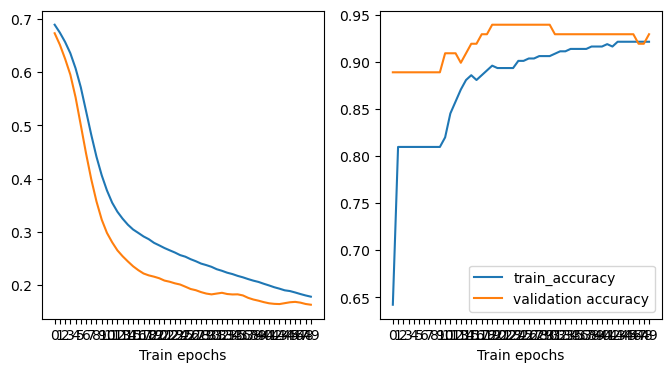

Test Accuracy: 0.8790


In [102]:
print('Test Accuracy: %1.4f' %train_and_evaluate(
                       hidden_layer_sizes=[64,32],
                       activation='relu',
                       optimizer='Adam',
                       learning_rate=0.001,
                       num_epochs=50))